In [1]:
import anndata as ad
import scanpy as sc

import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

from scGPD import scGPD, ExpressionDataset,PoiLoss

**Load and process dataset**

**Create training and validation splits**

In [2]:
adata = sc.read_h5ad("/gpfs/gibbs/project/zhao/yg399/gene_panel_design/dataset/single_cell/human_hvg.h5ad")

In [3]:
adata = adata[:,adata.var['highly_variable']]

In [4]:
category_to_num = {category: idx for idx, category in enumerate(np.unique(adata.obs['cell_type1']))}

# Convert the categories to numbers
label = np.array([category_to_num[category] for category in adata.obs['cell_type1']])

adata.obs['label'] = label
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X)
adata.layers['log1pcpm'] = csr_matrix(adata.layers['log1pcpm'])

/tmp/ipykernel_1758658/24599748.py:6: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['label'] = label


In [5]:
adata

AnnData object with n_obs × n_vars = 8569 × 5000
    obs: 'human', 'cell_type1', 'label'
    var: 'highly_variable'
    uns: 'hvg', 'log1p'
    layers: 'log1pcpm'

In [21]:
#use stratifiedkfold to split the data according to available labels
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
train_idx, test_idx = next(skf.split(adata.X, adata.obs["label"]))

adata_train = adata[train_idx]
adata_val = adata[test_idx]

In [22]:
# load covariance 
cov = pd.read_csv('/gpfs/gibbs/project/zhao/yg399/gene_panel_design/dataset/single_cell/human_cov.csv')
epsilon = 1e-5 ## add residuals
cov = cov + epsilon * np.eye(cov.shape[0])
L = np.linalg.cholesky(np.matrix(cov))
L = torch.from_numpy(L)

In [25]:
from tqdm import tqdm
train_dataset = ExpressionDataset(adata_train.X, adata_train.X)
val_dataset = ExpressionDataset(adata_val.X, adata_val.X)

device = torch.device(torch.cuda.current_device() if torch.cuda.is_available() else 'cpu')

print(f"Using device: {device}")
# step 1 
selector_1 = scGPD(train_dataset,
                   val_dataset,
                   hidden = [128,128],
                   L = L.float(),
                   loss_fn=PoiLoss(),
                   device=device)

# Coarse removal of genes
print('Starting')
candidates, _ = selector_1.eliminate(target=500,max_nepochs=150,lam_init=0.0000357,verbose=False)
print('Completed')

Using device: cpu
Starting
trying lam = 0.000036


lam = 0.000036 yielded 578 genes
Completed


In [32]:
# step 2
train_dataset = ExpressionDataset(adata_train.layers['log1pcpm'][:,candidates], adata_train.obs['label'].values)
val_dataset = ExpressionDataset(adata_val.layers['log1pcpm'][:,candidates], adata_val.obs['label'].values)

num_genes_list = [256]
scGPD_result = {}

# use the CrossEntropy loss for classification task.
selector = scGPD(train_dataset,
                   val_dataset,
                   loss_fn=torch.nn.CrossEntropyLoss(),
                   L = L.float(),
                   device=device)

print('Selecting genes')
for num in num_genes_list:
    inds, model = selector.select(num_genes=num, max_nepochs=280,verbose=True)
    scGPD_result[num] = inds
print('Done')

Selecting genes
assuming loss function CrossEntropyLoss() requires 14 outputs


Training epochs:   0%|          | 0/280 [00:00<?, ?it/s]

done, selected 256 genes
Done


/gpfs/gibbs/project/zhao/yg399/conda_envs/gene_panel/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/zhao/yg399/conda_envs/gene_panel/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


<AxesSubplot:title={'center':'cell_type1'}, xlabel='UMAP1', ylabel='UMAP2'>

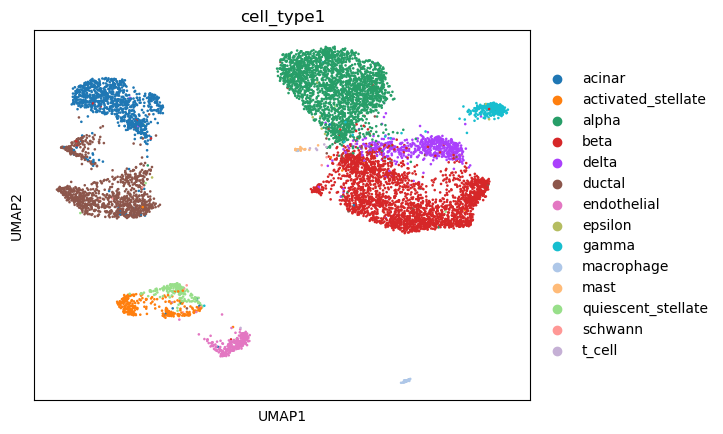

In [39]:
import umap
adata_sub = adata[:,candidates][:,scGPD_result[256]]
sc.pp.scale(adata_sub, max_value=10)
sc.tl.pca(adata_sub, svd_solver="arpack", n_comps=50)

# umap
reducer = umap.UMAP(n_neighbors=30,
                    n_components=2,
                    metric="correlation",
                    n_epochs=None,
                    learning_rate=1.0,
                    min_dist=0.3,
                    spread=1.0,
                    set_op_mix_ratio=1.0,
                    local_connectivity=1,
                    repulsion_strength=1,
                    negative_sample_rate=5,
                    a=None,
                    b=None,
                    random_state=1234,
                    metric_kwds=None,
                    angular_rp_forest=False,
                    verbose=False)
embedding = reducer.fit_transform(adata_sub.obsm['X_pca'])
adata_sub.obsm["X_umap"] = embedding
sc.pl.umap(adata_sub, color=["cell_type1"],show=False)

In [41]:
# list genes
adata[:,candidates][:,scGPD_result[256]].var_names

Index(['ADM', 'AGTRAP', 'AKR1C1', 'AKR1C3', 'ALDH1A1', 'AMBP', 'AMPD2',
       'AMY2A', 'ANGPTL4', 'ANKRD37',
       ...
       'VCAN', 'VEGFA', 'VGF', 'VWA5A', 'WARS', 'YPEL2', 'ZFP36', 'ZNF395',
       'ZNF396', 'pk'],
      dtype='object', length=256)